In [1]:
%load_ext autoreload
%autoreload 2

import os
from travel.constants import MODEL_CACHE_DIR
os.environ['HF_HOME'] = MODEL_CACHE_DIR

In [2]:
!nvidia-smi

Mon Apr 29 09:53:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:24:00.0 Off |                    0 |
|  0%   26C    P8              22W / 300W |      4MiB / 46068MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# CaptainCook4D Data

In [27]:
from travel.data.captaincook4d import CaptainCook4DDataset

PARTITION = "val"

# Load mistake detection dataset
dataset = CaptainCook4DDataset(data_split=PARTITION,
                               debug_n_examples_per_class=20)

In [1]:
import matplotlib.pyplot as plt

RETRIEVE_ID = "1_37_0"
RETRIEVE_TIMES = [
                14.0,
                16.0,
                18.0,
                22.0,
                24.0,
                26.0,
                28.0,
                30.0,
                32.0,
                34.0
            ]

# RETRIEVE_ID = "10_46_1"
# RETRIEVE_TIMES = [
#                 0.0,
#                 2.0,
#                 4.0,
#                 6.0,
#                 10.0,
#                 14.0,
#                 16.0,
#                 18.0,
#                 20.0,
#                 22.0,
#                 24.0,
#                 24.516
#             ]

# RETRIEVE_ID = "1_37_2"
# RETRIEVE_TIMES = [
#                 0.0,
#                 6.0,
#                 80.0
#             ]

try:
    retrieve_example = [example for example in dataset if example.example_id == RETRIEVE_ID][0]
except:
    print(f"Could not find CaptainCook4D example {RETRIEVE_ID}.")
    raise

for time in RETRIEVE_TIMES:
    found_frame = False
    for frame, frame_time in zip(retrieve_example.frames, retrieve_example.frame_times):
        if round(frame_time, 1) == round(time, 1):
            found_frame = True
            plt.imshow(frame)
            plt.title(f"Example {retrieve_example.example_id} - Time {round(time,1)}")
            plt.show()
    if not found_frame:
        print(f"Could not find frame at time {time} in example {retrieve_example.example_id}.")

Could not find CaptainCook4D example 1_37_0.


NameError: name 'dataset' is not defined

In [28]:
from travel.constants import MODEL_CACHE_DIR
import os
os.environ['HF_HOME'] = MODEL_CACHE_DIR

from travel.model.vqg import load_vqg_outputs

from transformers import AutoProcessor, AutoModelForVision2Seq, Owlv2Processor, Owlv2ForObjectDetection

vqg_outputs = load_vqg_outputs("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results/vqg/VQG_Llama-2-7b-hf_icl5_20240227131939")

# Load OWL object detector for filtering frames, and filter frames
detector_processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16")
detector = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16", load_in_8bit=True)



The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [29]:
from travel.model.grounding import filter_frames_by_target_objects

dataset = filter_frames_by_target_objects(dataset, detector, detector_processor, vqg_outputs)

filtering frames: 100%|██████████| 40/40 [00:00<00:00, 18676.63it/s]

Filtered out 576 video frames (904 -> 328).


# Ego4D Data

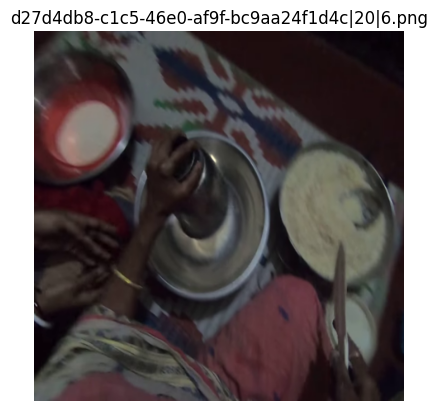

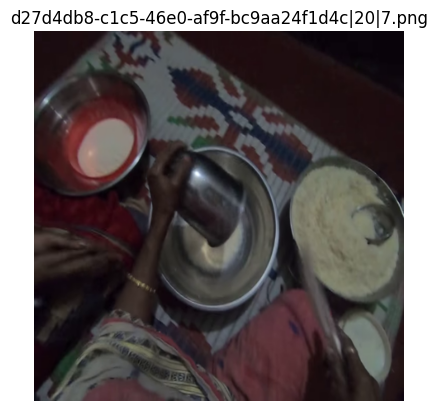

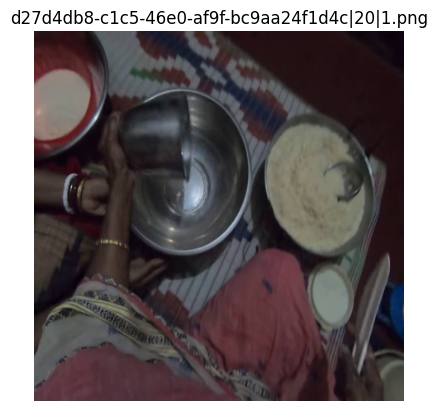

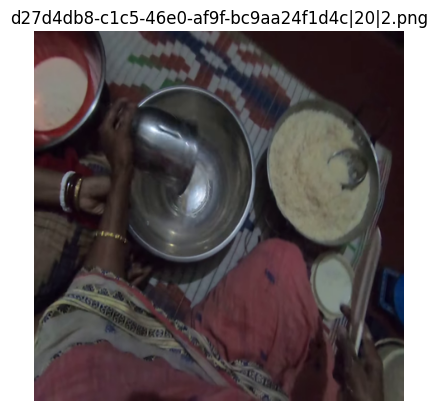

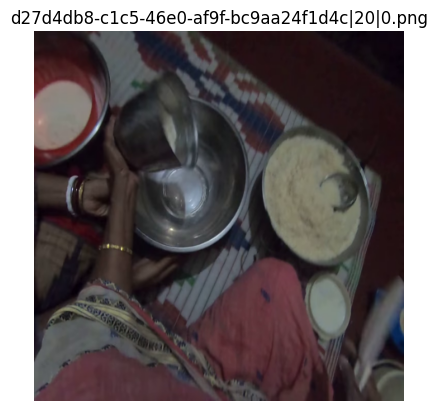

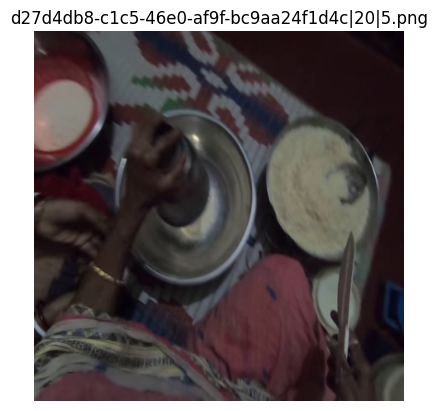

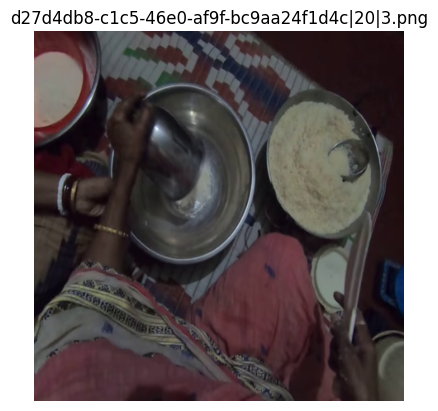

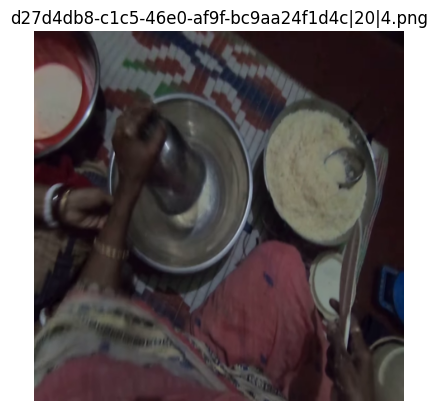

In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

frame_dir = "/nfs/turbo/coe-chaijy/generated-data/ego4d/v2/fho_main_val-critical-frames-subsample-8/d27d4db8-c1c5-46e0-af9f-bc9aa24f1d4c|20"

# Iterate through the files in the directory
for filename in os.listdir(frame_dir):
    if filename.endswith(".png"):
        # Load and display the image
        img_path = os.path.join(frame_dir, filename)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(filename)
        plt.axis('off')  # Hide the axis
        plt.show()

In [11]:
import json

annotations = json.load(open("/home/sstorks/coe-chaijy-unreplicated/datasets/ego4d/v2/annotations/fho_main.json", "r"))


: 

In [ ]:
print(annotations.keys())

# VQG Training Data from Ego4D

In [2]:
from matplotlib import pyplot as plt
import os
import pickle
from pprint import pprint

RESULTS_DIR = "coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results/vqg_learning/VQG_data_debug_Llama-2-7b-hf_icl5_20240429110645"
data_path = os.path.join(RESULTS_DIR, "frameVQA_examples.pkl")
data = pickle.load(open(data_path, "rb"))

print(f"{len(data)} examples generated")
for example in data[100:120]:
    # pprint(example)

    for question_set in example.candidate_question_sets:
        fig, ax = plt.subplots(figsize=(8, 10))

        # Display the image
        ax.imshow(example.frame)

        # Adding text on the image at different positions
        text_offset = 30  # Pixel offset for text below the image
        ax.text(0, example.frame.height + 35, question_set.procedure_description, fontsize=9, style='italic')
        ax.text(0, example.frame.height + 70, f"{question_set.questions[0]} ({question_set.answers[0].name})", fontsize=9)
        ax.text(0, example.frame.height + 105, f"{question_set.questions[1]} ({question_set.answers[1].name})", fontsize=9)

        # Set the limits of the axes and hide them
        ax.set_xlim([0, example.frame.width])
        ax.set_ylim([example.frame.height + text_offset + 50, -10])  # Expanded to fit the text below the image
        ax.axis('off')

        # Display the figure
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results/vqg_learning/VQG_data_debug_Llama-2-7b-hf_icl5_20240429110645/frameVQA_examples.pkl'